⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ 
# Disclaimer
👮🚨This notebook is sort of like my personal notes on this subject. It will be changed and updated whenever I have time to work on it. This is not meant to replace a thorough fluid substitution workflow. The intent here is make the major assumptions underlying the process of evaluating the affect of fluid fill on seismic response a little more clear, as well as provide references and background in literature for further study.🚨

At some point I will probably generalize this better so it can be used with real curves. For now it creates some fake blocked logs you can edit just to get a feel for how fluid sub works and how the different fluid fills might look in seismic. Also, currently the rocks are monomineralic. 

#### Important Note: 
The proper conditioning of logs, calibration of water saturations, reservoir selection for substituion, and rock and mineral parameter selection and calibration are extremely important to the reliability of a fluid substitution's output. These are good candidates for additional tutorials.

This tutorial is focused on the basic workflow from the geophysical perspective and therefore assumes the labor intensive petrophysical work mentioned above is both completed and reliable.

##### Notes for future:
* Incorporate a tuning section
* Put the whole thing in a function and see if I can get interact working so I can just use sliders to change parameters
* Generalize so real .las files can be loaded
* Complete the implementation of the B&W fluid property equations
* Fix a few of the hard-coded parts
* Figure out why fill_betweenx isn't working

##### Come up and ask me questions on 7 if anything appears to be amiss! -Thomas

⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ 

[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/tccw/geotools/master?filepath=tutorials%2FFluidSubstitution.ipynb)

In [4]:
from collections import namedtuple
from scipy.stats import linregress
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import bruges as b

from IPython.display import HTML

%matplotlib inline

In [5]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<font size="6" color="red">The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.</font>''')

# Porosity and Saturation effects on AVO

### Gassmann's Equations
Gassmann's equations (seen below) describes how the bulk modulus (ratio of pressure change to volume change) of a saturated rock changes as the saturating fluid changes. It provides a useful means for modeling how the seismic response of a formation may change for different filling fluids.

For a discussion of the origin and derivation of Gassmann's equations, see Berryman, 2000 (https://doi.org/10.1190/1.1444667) 

$$\textbf{Gassmann Equations}$$
$$\frac{K_{sat}}{K_{mineral} - K_{sat}} = \frac{K_{dry}}{K_{mineral} - K_{dry}} + \frac{K_{fluid}}{\phi(K_{mineral} - K_{fluid})}$$

$$\mu_{sat} = \mu_{dry}$$

$K_{dry} = \text{Dry rock bulk modulus}$  
$K_{mineral} = \text{Mineral bulk modulus}$  
$K_{sat} = \text{Saturated rock bulk modulus}$  
$K_{fluid} = \text{Fluid bulk modulus}$   
$\mu_{sat} = \text{Shear modulus of the saturated rock}$  
$\mu_{dry} = \text{Shear modulus of the dry rock}$

### Assumptions

1. Porous material is isotropic, elastic, monomineralic, and homogeneous
2. Pore sapce is well connected and in pressure equilibrium
3. Medium is a closed system with no pore fluid movement across boundaries
4. No checmical interaction between fluids and rock frame (i.e. no diagenetic processes)
5. Frequency effects are negligible when considering the measurements. Gassmann's equations are valid only for seismic frequencies (<100 Hz from Mavko, 1998).

These assumptions are often violated in real reservoirs. However, Gassmann's model is still generally the preferred model as it can be easily parameterized. A number of publications exist which suggest ways to modify inputs or assumptions to make these relationships more applicable to more variable rocks. A good general discussion of this can be found in Rob Simm's 2007 article "Practical Gassmann fluid substitution in sand/shale sequences [DOI: 10.3997//1365-2387.2007030](http://dreamcell-dev.co.uk/rpa/papers_downloads/RPA_simm_2007.pdf).

Below we will look at the Avseth et. al, 2006 fluid substitution workflow, which is used in this notebook.

#### Gassmann fluid substitution recipe from Avseth, 2006$^{[1]}$

$\textbf{Step 1:}$ Extract the dynamic bulk and shear moduli from $V_{p}^{(1)}$, $V_{s}^{(1)}$ , and $\rho^{(1)}$:

$K^{(1)}\ =\ \rho((V_{p}^{(1)})^2 - \frac{4}{3}(V_{s}^{(1)})^2)\\ \mu^{(1)}\ =\ \rho(V_{s}^{(1)})^2$

$\textbf{Step 2:}$ Apply Hassmann's relation to transform the bulk modulus:

$\frac{K_{sat}^{(2)}}{K_{mineral}\ -\ K_{sat}^{(2)}}\ -\ \frac{K_{fluid}^{(2)}}{\phi(K_{mineral}\ -\ K_{fluid}^{(2)})}\ =\ \frac{K_{sat}^{(1)}}{K_{mineral}\ -\ K_{sat}^{(1)}}\ -\ \frac{K_{fluid}^{(1)}}{\phi(K_{mineral}\ -\ K_{fluid}^{(1)})}$

$\textbf{Step 3:}$ Leave the shear modulus unchanged:

$\mu_{sat}^{(1)} = \mu_{sat}^{(2)}$

$\textbf{Step 4:}$ Remember to correct the bulk density for the fluid change:

$\rho^{(2)} = \rho^{(1)} + \phi(\rho_{fluid}^{(2)} - \rho_{fluid}^{(1)})$

$\textbf{Step 5:}$ Reassemble the velocities:

$V_p^{(2)} = \sqrt{\frac{K_{sat}^{(2)} + \frac{4}{3} \mu_{sat}^{(2)}}{\rho^{(2)}}}$

$V_s^{(2)} = \sqrt{\frac{\mu_{sat}^{(2)}}{\rho^{(2)}}}$

Below is a basic, blocked log example of Gassmann fluid substitution to help explore the affects of different fluids on the seismic response.

$^{[1]}$Avseth, Per; Mukerji, Tapan; Mavko, Gary. Quantitative Seismic Interpretation: Applying Rock Physics Tools to Reduce Interpretation Risk (Kindle Locations 582-584). Cambridge University Press. Kindle Edition. 

In [6]:
HTML('<font color="red">The B&W implementation is incomplete and needs more testing for verification</font>')

### Batzle and Wang fluid calculations

The most common, and likely most useful, method for calcualting the properties of fluids of varying composition, temperature, and pressure are emperical fluid equations from Batzle & Wang 1992. 

These functions take pressure in MPa and temperature in Centigrade. It outputs density in g/cc, velocity in m/s, and bulk modulus (K) in GPa.  

$\textbf{Equations for dead oil:}$

$API = \frac{141.5}{\rho_0} - 131.5$

$\rho_P = \rho_0 + (0.00277P - 1.71 \times 10^{-7}P^3)(\rho_0 - 1.15)^2 + 3.49 \times 10^{-4}P$

$\rho = \rho_P / [0.972 + 3.81 \times 10^{-4}(T + 17.78)^{1.175}]$

$V = 15450(77.1 + API)^{-1/2} - 3.7T + 4.64P + 0.0115(0.36API^{1/2} - 1)TP$

In [7]:
def bwOil(temp,pressure,API, gasGravity,live = False):
    # Pressue in MPa, Temp in C
    P = pressure
    T = temp
    G = gasGravity
    rho0 = 141.5 / (API + 131.5)
    rhoP = rho0 + (0.00277*P - 1.71e-7 * P**3)*(rho0 - 1.15)**2 + 3.49e-4 * P
    
    #Rg = 0.02123*G*(P*np.exp(4.072/rho0 - 0.00377*T))**1.205 # Eqtn 21a
    Rg = 2.03*G*(P*np.exp(0.02878*API - 0.00377*T))**1.205 # Eqtn 21b
    Bo = 0.972 + 0.00038*(2.4 * Rg * np.sqrt(G/rho0) + T + 17.8)**1.175 # Eqtn 23
    rhoPprime = (rho0/Bo) * (1 + 0.001*Rg)**(-1) # Eqtn 22
    
    if live == False:
        rho = rhoP / (0.972 + 3.81e-4 * (T + 17.78)**1.175) #etqn 20
        vp = 15450*(77.1 + API)**(-1/2) - 3.7*T + 4.64*P + 0.0115*(0.36*API**(1/2) - 1)*T*P
    elif live == True:
        rho = (rho0 + 0.0012*G*Rg)/Bo
        vp = 2096 * np.sqrt(rhoPprime/(2.6 - rhoPprime)
                           ) - 3.7*T + 4.64*P + 0.0115*(4.12 * (1.08 * rhoPprime**-1 - 1) - 1)*T*P
    
    K = (rho * vp**2)/1e6
    
    return K, rho * 1000

def bwBrine(temp,pressure,salinity):
    
    '''
    Pressue in MPa, Temp in C, salinity is weight fraction (i.e. ppm/1e6)
    The velocity is not agreeing with the FPE from CREWES but I can't figure out why

    '''

    S = salinity
    P = pressure
    T = temp
    
    #eqtn 27 - 29
    rhow = 1 + 1e-6 * (-80*T - 3.3*T**2 + 0.00175*T**3 + 489*P - 
                      2*T*P + 0.016*T**2 * P - 1.3e-5 * T**3 * P - 
                      0.333*P**2 - 0.002*T*P**2)
    rhobr = rhow + S*(0.668 + 0.44*S + 1e-6 * (300*P - 2400*P*S + 
                                               T*(80 + 3*T - 3300*S - 13*P + 47*P*S)))

    w = np.array([[1402.85, 1.524, 3.437e-3, -1.197e-5],
                 [4.871, -0.0111, 1.739e-4, -1.628e-6],
                 [-0.04783, 2.747e-4, -2.135e-6, 1.237e-8], 
                 [1.487e-4, -6.503e-7, -1.455e-8, 1.327e-10], 
                 [-2.197e-7, 7.987e-10, 5.230e-11, -4.614e-13]], dtype = float)
    
    vpW = np.sum(w[i][j]*np.power(P,[i])*np.power(T,[j]) for i in range(0,4) for j in range(0,3))
    
    vpB = vpW + S*(1170 - 9.6*T + 0.055*T**2 - 8.5e-5 * T**3 + 2.6*P 
                   - 0.0029*T*P - 0.0476*P**2)+ S**1.5 * (780 -10*P + 0.16*P**2) - 820*S**2
    
    K = (rhobr * vpB**2)/1e6
    
    rhobr = np.array(rhobr)
    vpB = np.array(vpB)
    K = np.array(K)
    
    return K, rhobr * 1000


## Input data

In [78]:
# Pressure (P), Temperature (T), API, Gas Gravity (G), Salinity weight fraction (S)
# Deepwater GOM pressures and temperatures
P = 100 # MPa
T = 85.5 # degrees C
API = 35
G = 0.6
S = 0.088 # ppm/1e6 

# In situ parameters are GOM clean sand 100% brine saturated values
vpInSitu = 3550. # m/s
vsInSitu = 1900. # m/s
rhobInSitu = 2240. # kg/m^3
top_depth = 400
base_depth = 500
resThickness = 100. # thickness in meters

KflInitial, rhoflInitial = bwBrine(P,T,0.025) # Inital brine (this was taken from some GOM well data)
KflBrine, rhoflBrine = bwBrine(P,T,S)
KflOil, rhoflOil = bwOil(P,T,API,G,live = False)
KflGas, rhoflGas = 0.374 * 1e9, 338 # gas Gpa (convert to pascals)
Kmineral = 37.0 * 1e9 # Gpa Quartz from tables (convert to pascals 1e9)

# Convert bulk Modluii to pascals from GPa
KflInitial = KflInitial * 1e9 # convert to pascals
KflBrine = KflBrine * 1e9
KflOil = KflOil * 1e9

# encasing rock properties
vpEncase, vsEncase, rhobEncase = 3300.,1500.,2400.

phi = np.round((2650 - rhobInSitu)/(2650 - rhoflInitial),2) # SS density porosity

In [79]:
bwOil(P,T,API,G,live = False)
bwBrine(P,T,0.025)

(array([3.03367568]), 1009.8357930000002)

#### Make the wavelet (currently only supports Ricker and Ormsby wavelets)

* Here I am making the sample 1 ms even though most seismic is 2 ms
* This allows me to make a smooth synthetic without having to interpolate later

In [80]:
# wavelet parameters
f = 35 #frequency of ricker wavelet
f_arr = [8,12,50,65]
duration = 0.128 # length of wavelet in seconds
dt = 0.001 # size of time sample for
dz = 1 # for later (should probably be located somewhere else)

wvlt, t_basis = b.filters.ricker(duration, dt, f, return_t=True)
wvlt_orm, t_basis_orm = b.filters.ormsby(duration, dt, f_arr,return_t=True)

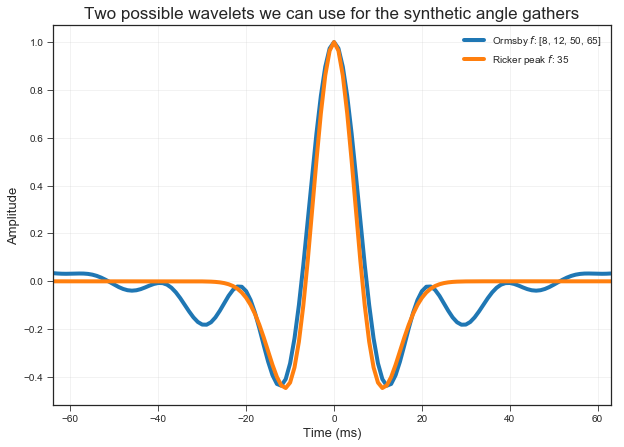

In [81]:
sns.set_style(style="ticks")

plt.figure(figsize=(10,7))
plt.plot(t_basis * 1e3, wvlt_orm, label = f'Ormsby $f$: {f_arr}', linewidth=4)
plt.plot(t_basis * 1e3, wvlt, label = f'Ricker peak $f$: {f}', linewidth=4)
plt.xlabel('Time (ms)', size=13)
plt.ylabel('Amplitude', size=13)
plt.title('Two possible wavelets we can use for the synthetic angle gathers', size=17)
plt.xlim(t_basis.min() * 1e3,t_basis.max() * 1e3)
plt.grid(alpha=0.3)
plt.legend()


#### Create in situ block curves

In [82]:
shape = (1000,)

block_vp, block_vs, block_rhob = np.zeros(shape), np.zeros(shape), np.zeros(shape)
block_vp[:], block_vs[:], block_rhob[:] = vpEncase, vsEncase, rhobEncase
block_vp[top_depth:base_depth], block_vs[top_depth:base_depth], block_rhob[top_depth:base_depth] = vpInSitu, vsInSitu, rhobInSitu

#### Naive fluid sub from Avseth, 2006

In [83]:
rhofl = np.array([rhoflInitial,rhoflBrine, rhoflOil, rhoflGas])
Kfls = np.array([KflInitial,KflBrine, KflOil, KflGas])
names = ['Initial', 'Brine', 'Oil', 'Gas']

# Order is initial fluid, user defined brine, user defined oil, user defined gas

subs_depth = [b.rockphysics.avseth_fluidsub(
    block_vp,block_vs,block_rhob,phi,rhofl[0], rhofl[i],
    Kmineral,Kfls[0], Kfls[i]) for i in range(len(Kfls))]

subs_depth = {k:v for k,v in zip(names,subs_depth)}

# Resubbing in the old velocities for the encasing rock. 
# There must be a better way to approach this. Will have to think about it more later.
for key in names:
    getattr(subs_depth[key],'Vp')[:top_depth]  = vpEncase
    getattr(subs_depth[key],'Vp')[base_depth:]  = vpEncase
    getattr(subs_depth[key],'Vs')[:top_depth]  = vsEncase
    getattr(subs_depth[key],'Vs')[base_depth:]  = vsEncase
    getattr(subs_depth[key],'rho')[:top_depth]  = rhobEncase
    getattr(subs_depth[key],'rho')[base_depth:]  = rhobEncase


### Convert all the curves from depth to time

In [84]:
curves=['Vp', 'Vs', 'rho']
twt_tmp = [b.transform.time_to_depth(
    getattr(subs_depth[n],c),getattr(subs_depth[n],'Vp'), dt, dz) for  n in names for c in curves]

### Do some organization to make it easier to plot
* Make sure to use the updated Vp curve for each fluid subbed case for correct timing
* Create the different TWT arrays for plotting

In [85]:
twt_tmp_composite = [twt_tmp[x:x+3] for x in range(0, len(twt_tmp),3)]

twt_curves = namedtuple('TWTResults',('Vp','Vs','rho'))
subs_twt = [twt_curves(*twt_tmp_composite[i]) for i in range(len(names))]
subs_twt = {k:v for k,v in zip(names,subs_twt)}


twts = {key:np.linspace(0,len(getattr(subs_twt[key],'Vp')) * dt,
                        len(getattr(subs_twt[key],'Vp'))) for key in names}

### Make the pre-stack synthetics

In [86]:
theta = np.arange(0,51,1)

reflectivity = {key:b.reflection.reflectivity(getattr(subs_twt[key],'Vp'),
                                         getattr(subs_twt[key],'Vs'),
                                         getattr(subs_twt[key],'rho'),theta=theta) for key in names}

prstk_gaths = {key:np.apply_along_axis(lambda x: np.convolve(wvlt, x, mode='same'),axis=1,arr=reflectivity[key]) for key in names}

# Get the index of the top of the reservoir in time
top_twt_index = np.argmax(reflectivity['Initial']!=0)

#### Calc intercept and gradient
* I am only going to use the first 30 degrees of the reflectivity series as beyond ~30 degrees reflectivity stops behaving linearly in reflectivity vs. $sin^2(\theta)$ space, therefore a linear approximation (like the one used for gradient / intercept) is not a hepful regression.

In [87]:
theta_grad = 30

refl = {k:reflectivity[k][:theta_grad,top_twt_index] for k in names}
sintheta = np.sin(np.radians(np.arange(0, theta_grad)))**2

int_grad = {k:linregress(sintheta,refl[k][:]) for k in names}

### Plot everything up (the hardest part!)

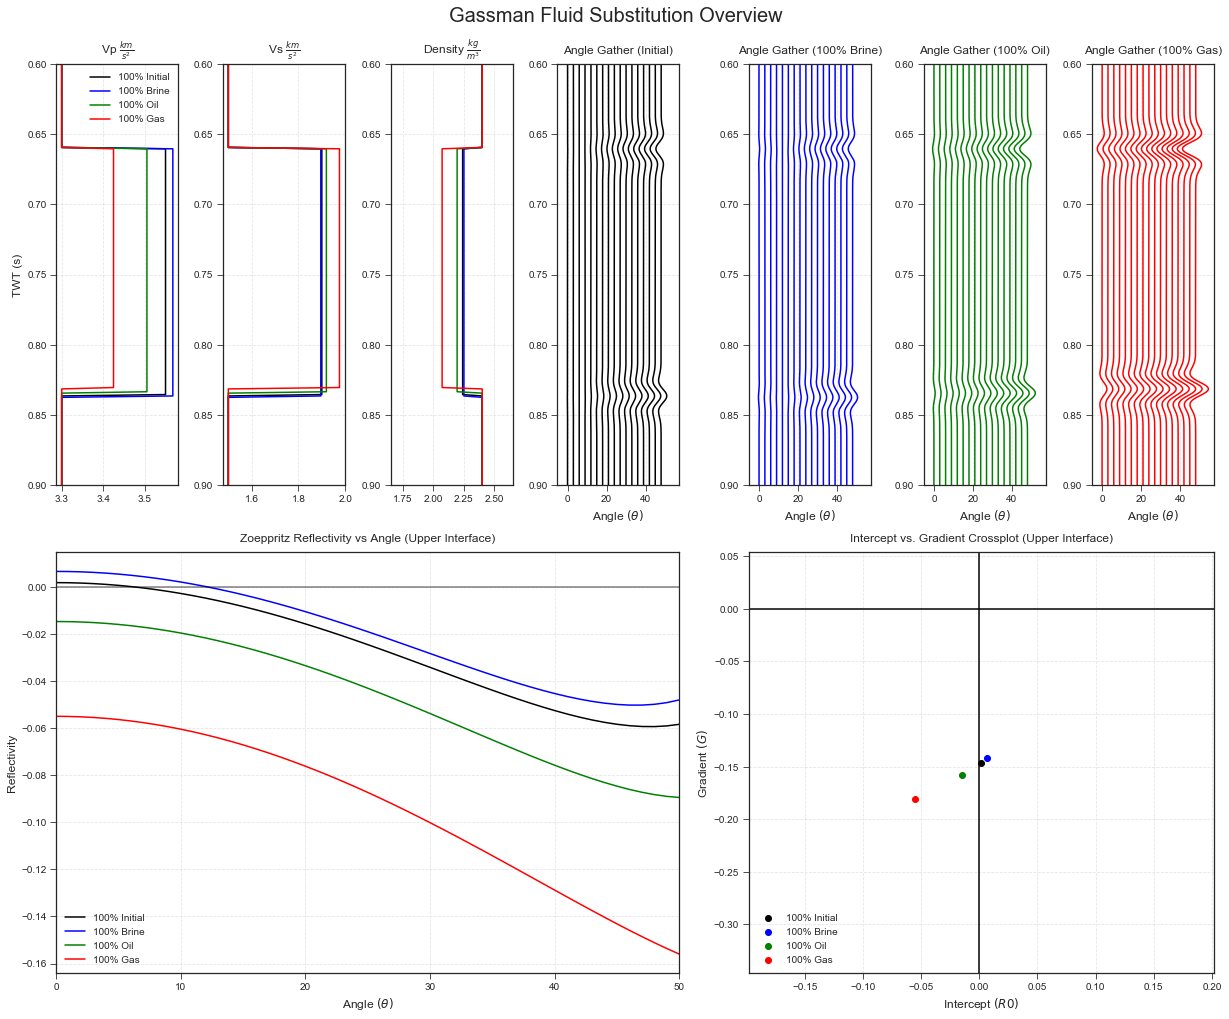

In [88]:
sns.set_style('ticks')

# Some useful stuff to initialize
depth = np.linspace(0,1000,1000)
gain = 45
colors=['k','b','g','r']
titles = [r'Vp $\frac{km}{s^2}$', r'Vs $\frac{km}{s^2}$', r'Density $\frac{kg}{m^3}$',
          'Angle Gather (Initial)', 'Angle Gather (100% Brine)', 'Angle Gather (100% Oil)', 'Angle Gather (100% Gas)']
curve_buffer_twt = 0.1

def format_axes(fig):
    titles = [r'Vp $\frac{km}{s^2}$', r'Vs $\frac{km}{s^2}$', r'Density $\frac{kg}{m^3}$',
          'Angle Gather (Initial)', 'Angle Gather (100% Brine)', 'Angle Gather (100% Oil)',
          'Angle Gather (100% Gas)', 'Zoeppritz Reflectivity vs Angle (Upper Interface)', 'Intercept vs. Gradient Crossplot (Upper Interface)']
    axes_label_size=12
    for i, ax in enumerate(fig.axes):
        ax.set_title(titles[i],y = 1.01)
        ax.tick_params(labelbottom=True, labelleft=True)
        ax.grid(alpha=0.5, linestyle='--')
    # labels
    for ax in (ax4,ax5,ax6,ax7):
        ax.set_xlabel(r'Angle $(\theta)$', size = 12)
    ax1.set_ylabel('TWT (s)', size=axes_label_size)
    ax8.set_ylabel('Reflectivity', size=axes_label_size)
    ax8.set_xlabel(r'Angle $(\theta)$', size=axes_label_size)
    ax9.set_ylabel('Gradient $(G)$', size=axes_label_size)
    ax9.set_xlabel('Intercept $(R0)$', size=axes_label_size)
    # limits
    ax1.set_ylim(0.6,0.9)
    ax3.set_xlim(1.65,2.65)
    ax8.set_xlim(0,theta.max())
    ax9.set_xlim(np.real(getattr(int_grad['Initial'],'intercept')) - 0.2, np.real(getattr(int_grad['Initial'],'intercept')) + 0.2)
    ax9.set_ylim(np.real(getattr(int_grad['Initial'],'slope')) - 0.2, np.real(getattr(int_grad['Initial'],'slope')) + 0.2)
    ax1.invert_yaxis()
    

fig = plt.figure(constrained_layout=True, figsize=(17,14))

gs = GridSpec(nrows=4, ncols=7, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[:2, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[:2, 2], sharey=ax1)
ax4 = fig.add_subplot(gs[:2, 3], sharey=ax1)
ax5 = fig.add_subplot(gs[:2, 4], sharey=ax1, sharex=ax4)
ax6 = fig.add_subplot(gs[:2, 5], sharey=ax1, sharex=ax4)
ax7 = fig.add_subplot(gs[:2, 6], sharey=ax1, sharex=ax4)
ax8 = fig.add_subplot(gs[2:,:4])
ax9 = fig.add_subplot(gs[2:,4:])

for key,c in zip(names, colors):
    ax1.plot(getattr(subs_twt[key],'Vp') / 1e3,twts[key], label=f'100% {key}', color=c)
    ax2.plot(getattr(subs_twt[key],'Vs') / 1e3,twts[key], label=f'100% {key}', color=c)
    ax3.plot(getattr(subs_twt[key],'rho') / 1e3,twts[key], label=f'100% {key}', color=c)
for i in range(0,theta.max(),3):
    ax4.plot(np.real(prstk_gaths['Initial'][i,:] * gain + i), twts['Initial'][:-1],color='k')
#     ax4.fill_betweenx(twts['Initial'][:-1], i, prstk_gaths['Initial'][i,:] * gain + i,'k', alpha=0.4)
    ax5.plot(np.real(prstk_gaths['Brine'][i,:] * gain + i), twts['Brine'][:-1],color='b')
    ax6.plot(np.real(prstk_gaths['Oil'][i,:] * gain + i), twts['Oil'][:-1],color='g')
    ax7.plot(np.real(prstk_gaths['Gas'][i,:] * gain + i), twts['Gas'][:-1],color='r')

np.argmax(reflectivity['Initial']!=0)
for k,c in zip(names,colors):
    ax8.plot(np.real(reflectivity[k][:,top_twt_index]), color=c, label=f'100% {k}')
    ax9.scatter(np.real(getattr(int_grad[k],'intercept')),np.real(getattr(int_grad[k],'slope')), color=c,label=f'100% {k}')

ax8.axhline(0, color='k', alpha=0.5)
ax9.axhline(color='k')
ax9.axvline(color='k')
ax1.legend()
ax8.legend()
ax9.legend()
    
fig.suptitle('Gassman Fluid Substitution Overview', size = 20, y = 1)
format_axes(fig)

# Uncomment the line below to save the figure. You may need to change the filepath.
# plt.savefig('GassmanFluidSubOverview.png', dpi=350,bbox_inches='tight')
plt.show()